In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
'''
  id - The image ID.
  organ - The organ that the biopsy sample was taken from.
  data_source - Whether the image was provided by HuBMAP or HPA.
  img_height - The height of the image in pixels.
  img_width - The width of the image in pixels.
  pixel_size - The height/width of a single pixel from this image in micrometers. 
    All HPA images have a pixel size of 0.4 µm. For HuBMAP imagery the pixel size is 0.5 µm for kidney,
    0.2290 µm for large intestine, 0.7562 µm for lung, 0.4945    for spleen, and 6.263 µm for prostate.
  tissue_thickness - The thickness of the biopsy sample in micrometers. All HPA images have a thickness of 4 µm.
    The HuBMAP samples have tissue slice thicknesses 10 µm for kidney, 8 µm for large intestine, 4 µm for spleen,
    5 µm for lung, and 5 µm for prostate.
  rle - The target column. A run length encoded copy of the annotations. Provided for the training set only.
  age - The patient's age in years. Provided for the training set only.
  sex - The sex of the patient. Provided for the training set only.
'''
train = pd.read_csv('./train.csv', encoding='utf8')

# Descripcion baga de los datos

In [3]:
train.describe()

,id,img_height,img_width,pixel_size,tissue_thickness,age
count,351.000000,351.000000,351.000000,3.510000e+02,351.0,351.000000
mean,16662.914530,2978.364672,2978.364672,4.000000e-01,4.0,60.364672
std,9863.945557,90.962085,90.962085,1.111808e-16,0.0,16.013327
min,62.000000,2308.000000,2308.000000,4.000000e-01,4.0,21.000000
25%,8229.000000,3000.000000,3000.000000,4.000000e-01,4.0,55.000000
50%,16609.000000,3000.000000,3000.000000,4.000000e-01,4.0,60.000000
75%,25630.500000,3000.000000,3000.000000,4.000000e-01,4.0,73.000000
max,32741.000000,3070.000000,3070.000000,4.000000e-01,4.0,84.000000


In [4]:
__quant = list(train.describe().columns)

for variable in train.columns:
  if (variable in __quant or variable == 'rle'): continue
  print(train[variable].unique())


['prostate' 'spleen' 'lung' 'kidney' 'largeintestine']
['HPA']
['Male' 'Female']


# Analisis Exploratorio

## Analisis variables cualitativas

### Organos conteo

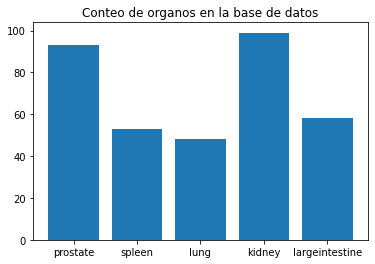

In [27]:
organs = []
counts = []
for organ in train['organ'].unique():
  organs.append(organ)
  counts.append(train['organ'].value_counts()[organ])
plt.bar(organs, counts)
plt.title('Conteo de organos en la base de datos')
plt.show()

### Organos y su distribucion de edad

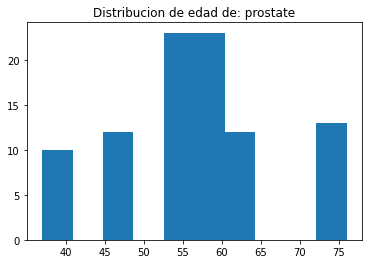

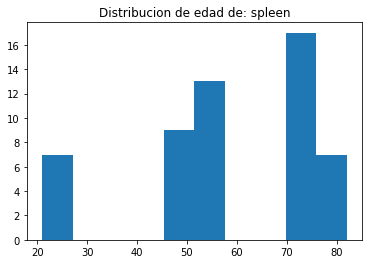

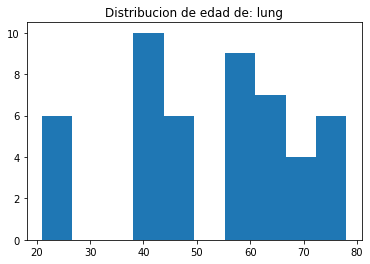

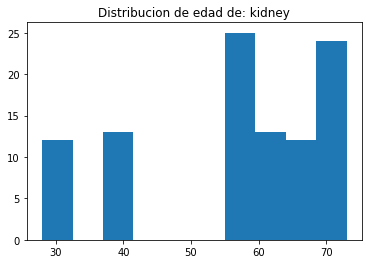

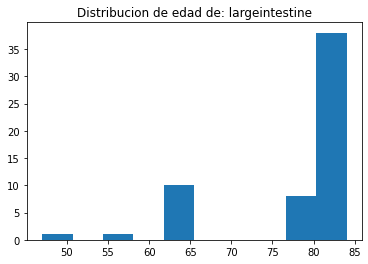

In [39]:
for organ in train['organ'].unique():
  plt.title('Distribucion de edad de: ' + organ)
  plt.hist(train.loc[train['organ'] == organ]['age'])
  plt.show()


### Organos y su distribucion por sexo

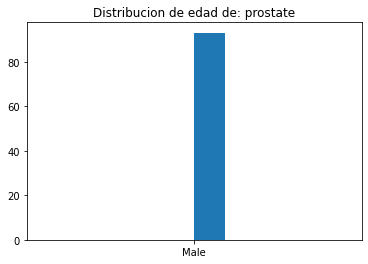

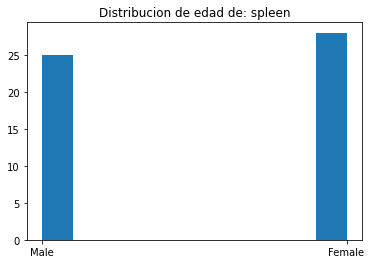

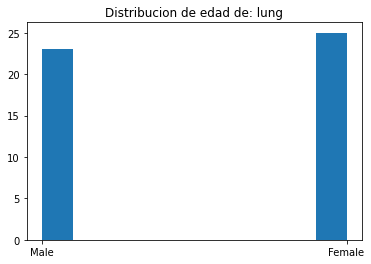

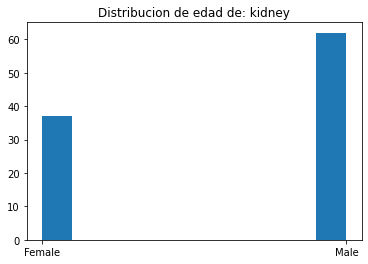

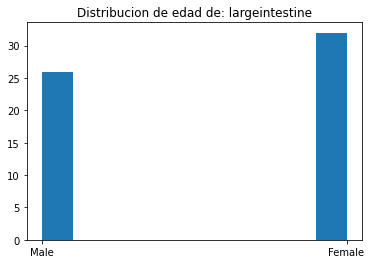

In [42]:
for organ in train['organ'].unique():
  plt.title('Distribucion de edad de: ' + organ)
  plt.hist(train.loc[train['organ'] == organ]['sex'])
  plt.show()

## Analisis variables cuantitativas

### Distribucion de edad

C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

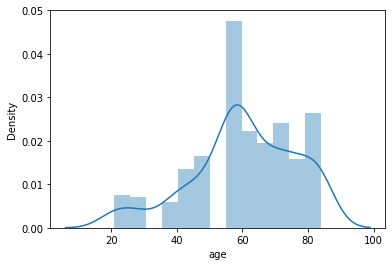

In [40]:
sns.distplot(train['age'])

### Distribucion de ancho de tejido

C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='tissue_thickness', ylabel='Density'>

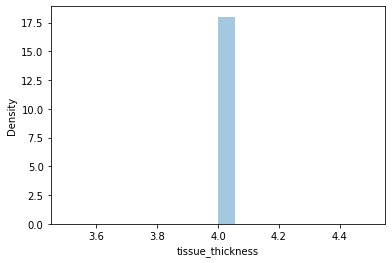

In [41]:
sns.distplot(train['tissue_thickness'])

## Analisis de fotografias

### Distribucion de tamanos de fotografias

#### Ancho

C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='img_width', ylabel='Density'>

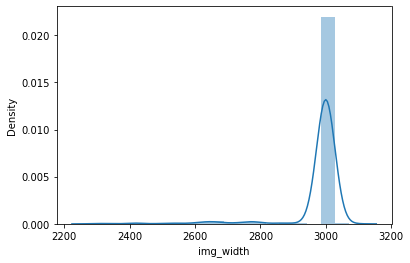

In [43]:
sns.distplot(train['img_width'])

#### Alto

C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='img_height', ylabel='Density'>

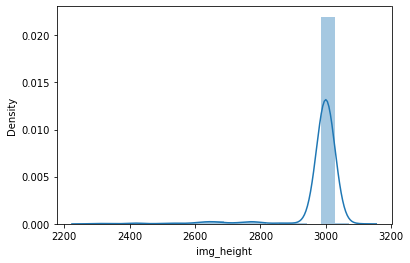

In [44]:
sns.distplot(train['img_height'])

#### Tamano pixel

C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


LinAlgError: singular matrix

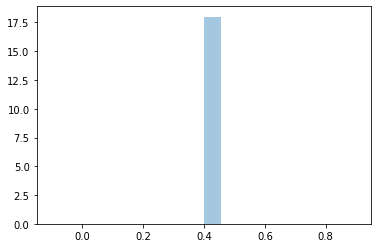

In [48]:
sns.distplot(train['pixel_size'])

#### Resolucion imagenes

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

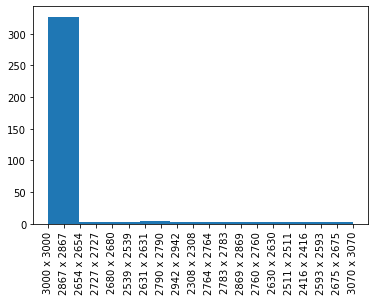

In [57]:
train['resolution'] = train['img_width'].astype(str) + ' x ' + train['img_height'].astype(str)
plt.hist(train['resolution'])
plt.xticks(rotation='vertical')

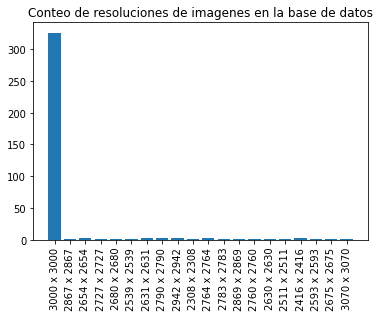

In [59]:
resolutions = []
counts = []
for resolution in train['resolution'].unique():
  resolutions.append(resolution)
  counts.append(train['resolution'].value_counts()[resolution])
plt.bar(resolutions, counts)
plt.title('Conteo de resoluciones de imagenes en la base de datos')
plt.xticks(rotation='vertical')
plt.show()